# Setup

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import requests
import re
from os import chdir, getcwd, listdir, mkdir
from os.path import join
import pkg_resources
import pickle
import nltk
nltk.download('averaged_perceptron_tagger')
from scipy.linalg import norm
from scipy.spatial.distance import cosine
from matplotlib import pyplot as plt

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\fabio\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
RUNNING_ON_COLAB = 'colab' in str(get_ipython())
HOME = getcwd()

In [3]:
if RUNNING_ON_COLAB == True:
    pass


else:
    URL_FAA_pr = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/Regulations/FAR_Part121_nodes.xlsx?raw=true"
    URL_ANAC_pr = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/Regulations/RBAC121_nodes.xlsx?raw=true"
    URL_TOKENIZER_pr = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/models/tokenizer___2021-04-16_16-04-53.h5?raw=true"
    URL_EMBEDDING_pr = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/models/embedding_layer___2021-04-16_16-04-53.h5?raw=true"
    URL_FAA_cl = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/Regulations/FAR_Part121_nodes_labelled.xlsx?raw=true"
    URL_ANAC_cl = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/Regulations/RBAC121_nodes.xlsx?raw=true"
    URL_TOKENIZER_cl = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/models/tokenizer___2021-04-16_15-56-43.h5?raw=true"
    URL_MODEL_cl = "https://github.com/fabio-a-oliveira/NLP_Regulations/blob/main/models/model___2021-04-16_15-56-43___Bidirectional_GRU_Softmax.h5?raw=true"

In [4]:
URLs = [URL_FAA_pr, URL_ANAC_pr, URL_TOKENIZER_pr, URL_EMBEDDING_pr, URL_FAA_cl, URL_ANAC_cl, URL_TOKENIZER_cl, URL_MODEL_cl]
filenames = ['FAA_pr.xlsx', 'ANAC_pr.xlsx', 'TK_pr.h5', 'EMB_pr.h5', 'FAA_cl.xlsx', 'ANAC_cl.xlsx', 'TK_cl.h5', 'MD_cl.h5']

chdir(HOME)
if 'temp' not in listdir():
    mkdir('temp')

chdir('temp')
for n in range(len(URLs)):
    r = requests.get(URLs[n])
    with open(filenames[n], 'wb') as file:
        file.write(r.content)

chdir(HOME)

In [5]:
filepath_FAA_pr = join(HOME, 'temp', filenames[0])
filepath_ANAC_pr = join(HOME, 'temp', filenames[1])
filepath_TK_pr = join(HOME, 'temp', filenames[2])
filepath_EMB_pr = join(HOME, 'temp', filenames[3])
filepath_FAA_cl = join(HOME, 'temp', filenames[4])
filepath_ANAC_cl = join(HOME, 'temp', filenames[5])
filepath_TK_cl = join(HOME, 'temp', filenames[6])
filepath_MD_cl = join(HOME, 'temp', filenames[7])

In [6]:
package_list = [pkg for pkg in pkg_resources.working_set]

if 'googletrans' not in [pkg.key for pkg in package_list]:
    ! pip install googletrans==3.1.0a0
import googletrans
    
if 'pdfplumber' not in [pkg.key for pkg in package_list]:
    ! pip install pdfplumber
import pdfplumber

---   
# Projection

Objective: find requirements of similar semantic content.

---

<img src="images/requirement_comparison.png">

## Setup

In [7]:
def relevant_words(excerpt):
    tokens = re.findall('[a-zA-Z]{3,}', excerpt)
    words, allowed_pos = [], ['NN','NNS','NNP','NNPS','JJ','RB','VB','VBG','VBN','VBP','VBZ','VBD']
    for item in nltk.pos_tag(tokens):
        if item[0] not in words and item[1] in allowed_pos:
            words.append(item[0])
    return words

def sorted_keywords(words, tokenizer):
    w,f = [], []

    for word in words:
        if word in tokenizer.word_index.keys():
            w.append(word)
            f.append(tokenizer.word_counts[word])

    sorting_indices = np.array(f).argsort()
    return np.array(w)[sorting_indices]

def jaccard_mod(string1, string2, tokenizer, max_words = None):
    # with max_words != None, repetitions are ignored, only the frequency in the original dictionary is used
    # with max_words == None, repetitions are somewhat accounted for (not very thoughtfully..)
    
    cutoff = .5
    
    if max_words == None:
        tokens1 = tokenizer.texts_to_sequences(relevant_words(string1))
        tokens2 = tokenizer.texts_to_sequences(relevant_words(string2))
    else:
        tokens1 = sorted_keywords(relevant_words(string1), tokenizer)
        tokens1 = tokenizer.texts_to_sequences(tokens1[:max_words])
        tokens2 = sorted_keywords(relevant_words(string2), tokenizer)
        tokens2 = tokenizer.texts_to_sequences(tokens2[:max_words])
        
    if len(tokens1) < 2 or len(tokens2) < 2:
        return 0
    else:
        embedding1 = embedding_layer(np.array(tokens1)).numpy().squeeze()
        norms1 = norm(embedding1, axis=1)
        embedding1 = embedding1[norms1 != 0]
        norms1 = norms1[norms1 != 0].reshape([-1,1])

        embedding2 = embedding_layer(np.array(tokens2)).numpy().squeeze()
        norms2 = norm(embedding2, axis=1)
        embedding2 = embedding2[norms2 != 0]
        norms2 = norms2[norms2 != 0].reshape([-1,1])

        cosine_similarity = np.matmul(embedding1, embedding2.T) / norms1 / norms2.T
        tril = np.ones_like(cosine_similarity) * (np.tril(cosine_similarity) != 0).astype(int)

        intersection = np.sum((cosine_similarity * cosine_similarity) > cutoff)
        union = cosine_similarity.shape[0] + cosine_similarity.shape[1] - intersection

        return intersection/union

In [8]:
df_FAA_pr = pd.read_excel(filepath_FAA_pr)[['title','requirement']]
df_ANAC_pr = pd.read_excel(filepath_ANAC_pr)[['title','requirement']]
translator = googletrans.Translator()

with open(filepath_TK_pr, 'rb') as file:
    tokenizer_pr = pickle.load(file)

with open(filepath_EMB_pr, 'rb') as file:
    embedding_layer = pickle.load(file)

## Demo: find FAA requirement corresponding to given ANAC requirement

* Choose ANAC requirement randomly
* Translate requirement
* Compare with list of FAA requirements
    - Tokenize
    - Filter parts-of-speech
    - Sort words according to importance
    - Identify similar words
    - Compare shared words
* Print best match

Requirement: RBAC 121.624(d)

121.624  Aeródromos de alternativa ETOPS 
(d) Ninguém pode listar um aeródromo como de alternativa ETOPS em um despacho ou liberação de voo a não ser que este aeródromo atenda aos requisitos previstos em 121.97(b)(1)(ii). 


Translated requirement:

121,624 Alternative ETOPS aerodromes
(d) No one may list an aerodrome as an ETOPS alternative in a dispatch or flight release unless this aerodrome meets the requirements of 121.97 (b) (1) (ii).


Match: FAR § 121.624(d)
Similarity index: 0.4375

Matching requirement text:

§ 121.624   ETOPS Alternate Airports.
(d) No person may list an airport as an ETOPS Alternate Airport in the dispatch or flight release unless that airport meets the public protection requirements of § 121.97(b)(1)(ii).



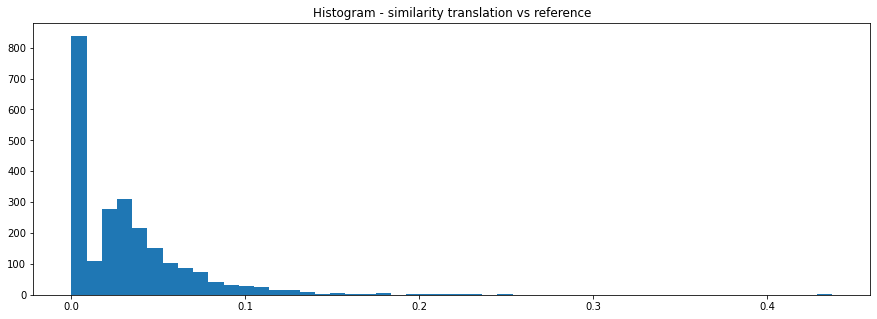

In [9]:
EXAMPLE_NUMBER = np.random.randint(0,df_ANAC_pr.shape[0])

req = df_ANAC_pr.requirement[EXAMPLE_NUMBER]
title = df_ANAC_pr.title[EXAMPLE_NUMBER]
print('Requirement: RBAC {}\n\n{}'.format(title,req))

translation = translator.translate(req, dest='en', src='pt').text

print('\n\nTranslated requirement:\n\n{}\n\n'.format(translation))

similarity = []
for ref in df_FAA_pr.requirement:
    similarity.append(jaccard_mod(translation, ref, tokenizer_pr))
    
match_index = np.array(similarity).argmax()
print('Match: FAR {}'.format(df_FAA_pr.title[match_index]))
print('Similarity index: {}\n'.format(np.max(similarity)))
print('Matching requirement text:\n\n{}'.format(df_FAA_pr.requirement[match_index]))

plt.figure(figsize = (15,5))
plt.hist(np.array(similarity), 50)
plt.title('Histogram - similarity translation vs reference')
plt.show()

## Demo: find match to user input

* Ask for requirement as input (in English)
* Compare with list of FAA requirements
    - Tokenize
    - Filter parts-of-speech
    - Sort words according to importance
    - Identify similar words
    - Compare shared words
* Print best match

-> Paste an operational requirement below:

Route requirements. General (a) Each certificate holder conducting regular operations in search of approval of a route must demonstrate: (1) that you are able to satisfactorily conduct regular operations between each aerodrome regular, or refueling, along that route or route segment; and

Match: FAR § 121.93(a)(1)
Similarity index: 0.9047619047619048

Matching requirement text:

§ 121.93   Route requirements: General.
(a) Each certificate holder conducting domestic or flag operations seeking a route approval must show - 
(1) That it is able to conduct satisfactorily scheduled operations between each regular, provisional, and refueling airport over that route or route segment; and 



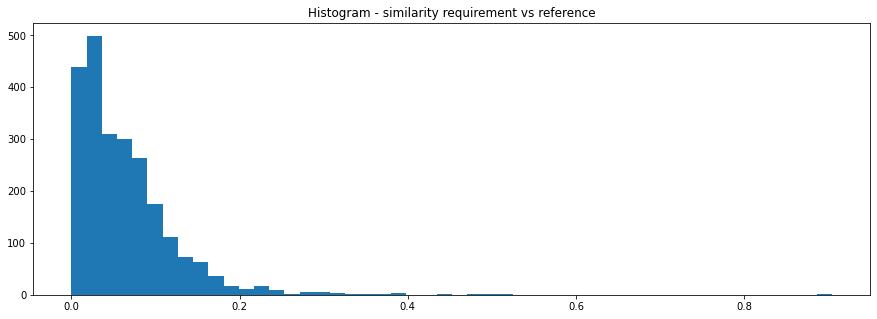

In [10]:
req = input('-> Paste an operational requirement below:\n\n')

similarity = []
for ref in df_FAA_pr.requirement:
    similarity.append(jaccard_mod(req, ref, tokenizer_pr))
    
match_index = np.array(similarity).argmax()
print('\nMatch: FAR {}'.format(df_FAA_pr.title[match_index]))
print('Similarity index: {}\n'.format(np.max(similarity)))
print('Matching requirement text:\n\n{}'.format(df_FAA_pr.requirement[match_index]))

plt.figure(figsize = (15,5))
plt.hist(np.array(similarity), 50)
plt.title('Histogram - similarity requirement vs reference')
plt.show()

## Improvements:

* Include more references (EASA, ICAO)
* Better parameter tuning:
    - number of relevant words to compare
    - threshold for 'similar' words
* Other keyword identification techniques
* Other similarity metrics
* Different word embeddings
* Sentence embeddings (compare meaning at sentence level)

---   
# Classification

Objective: read requirement and classify in either "Title Only", "Aircraft" or "Operator"   

-----   

<img src="images/requirement_classification.png">

# Setup

In [11]:
df_FAA_cl = pd.read_excel(filepath_FAA_cl)[['title','requirement','label','tag']]
df_ANAC_cl = pd.read_excel(filepath_ANAC_cl)[['title','requirement']] # + label + tag!!!
translator = googletrans.Translator()

with open(filepath_TK_cl, 'rb') as file:
    tokenizer_cl = pickle.load(file)
    
model = tf.keras.models.load_model(filepath_MD_cl)

In [12]:
sequence_length = 200

## Demo: classify random FAA requirement

* Select FAA part 121 requirement randomly
* Tokenize
* Pad/trim sequence to 200 tokens
* Run through classification model
* Choose class according to highest probability

In [13]:
EXAMPLE_NUMBER = np.random.randint(0,df_FAA_cl.shape[0])

req = df_FAA_cl.requirement[EXAMPLE_NUMBER]
title = df_FAA_cl.title[EXAMPLE_NUMBER]
correct_tag = df_FAA_cl.tag[EXAMPLE_NUMBER].title()
print('Requirement: {}\n\n{}'.format(title,req))

tokens = tokenizer_cl.texts_to_sequences([req])
padded_tokens = tf.keras.preprocessing.sequence.pad_sequences(tokens, maxlen = sequence_length)
X = tf.constant(np.array(padded_tokens))
prediction = model.predict(X)
predicted_prob = prediction.max()
predicted_label = prediction.argmax()
predicted_tag = ['Title Only', 'Aircraft', 'Operator'][predicted_label]

print('Predicted label: {}\nLevel of Confidence: {}%'.format(predicted_tag, np.round(100*predicted_prob,3)))
print('\nCorrect label: {}'.format(correct_tag))

Requirement: § 121.125(a)(2)

§ 121.125   Flight following system.
(a) Each certificate holder conducting supplemental operations must show that it has - 
(2) Flight following centers located at those points necessary - 
(i) To ensure the proper monitoring of the progress of each flight with respect to its departure at the point of origin and arrival at its destination, including intermediate stops and diversions therefrom, and maintenance or mechanical delays encountered at those points or stops; and 
(ii) To ensure that the pilot in command is provided with all information necessary for the safety of the flight. 

Predicted label: Operator
Level of Confidence: 99.957%

Correct label: Operator


## Demo: classify random ANAC requirement

* Select ANAC RBAC 121 requirement randomly
* Translate to English
* Tokenize
* Pad/trim sequence to 200 tokens
* Run through classification model
* Choose class according to highest probability

In [14]:
EXAMPLE_NUMBER = np.random.randint(0,df_ANAC_cl.shape[0])

req = df_ANAC_cl.requirement[EXAMPLE_NUMBER]
title = df_ANAC_cl.title[EXAMPLE_NUMBER]
#correct_tag = df_ANAC.tag[EXAMPLE_NUMBER].title()
print('Requirement: {}\n\n{}'.format(title,req))

translation = translator.translate(req, dest='en', src='pt').text

print('\n\nTranslated requirement:\n\n{}\n\n'.format(translation))

tokens = tokenizer_cl.texts_to_sequences([translation])
padded_tokens = tf.keras.preprocessing.sequence.pad_sequences(tokens, maxlen = sequence_length)
X = np.array(padded_tokens)
X = tf.constant(X)
prediction = model.predict(X)
predicted_prob = prediction.max()
predicted_label = prediction.argmax()
predicted_tag = ['Title Only', 'Aircraft', 'Operator'][predicted_label]

print('Predicted label: {}\nLevel of Confidence: {}%'.format(predicted_tag, np.round(100*predicted_prob,3)))
#print('\nCorrect label: {}'.format(correct_tag))

Requirement: 121.801(a)

121.801  Aplicabilidade 
(a) Esta subparte prescreve os equipamentos de emergência e de treinamento aplicáveis a todos os detentores de certificado que operem aviões no transporte de passageiros sob este regulamento. 


Translated requirement:

121,801 Applicability
(a) This subpart prescribes emergency and training equipment applicable to all certificate holders operating airplanes in the transportation of passengers under this regulation.


Predicted label: Operator
Level of Confidence: 98.309%


## Demo: classify user input

* Ask for requirement as input (in English)
* Tokenize
* Pad/trim sequence to 200 tokens
* Run through classification model
* Choose class according to highest probability

In [15]:
REQUIREMENT = input('-> Paste an operational requirement below:\n\n')

tokens = tokenizer_cl.texts_to_sequences([REQUIREMENT])
padded_tokens = tf.keras.preprocessing.sequence.pad_sequences(tokens, maxlen = sequence_length)
X = np.array(padded_tokens)
X = tf.constant(X)
prediction = model.predict(X)
predicted_prob = prediction.max()
predicted_label = prediction.argmax()
predicted_tag = ['Title Only', 'Aircraft', 'Operator'][predicted_label]

print('\nPredicted label: {}\nLevel of Confidence: {}%'.format(predicted_tag, np.round(100*predicted_prob,3)))

-> Paste an operational requirement below:

Route requirements. General (a) Each certificate holder conducting regular operations in search of approval of a route must demonstrate: (1) that you are able to satisfactorily conduct regular operations between each aerodrome regular, or refueling, along that route or route segment; and

Predicted label: Operator
Level of Confidence: 99.56%


## Improvements:

* More categories
* Feature engineering
* Larger dataset: more sophisticated models without overfitting
* Better embeddings: context sensitive, other datasets, multilingual, sentence embedding

## Teaser

### Applications of Natural Language Processing:

* ___Machine Translation___
* Speech Recognition
* Sentiment Analysis
* ___Question Answering___
* ___Summarization of Text___
* Chatbot
* Intelligent Systems
* ___Text Classification___
* Character Recognition
* Spell Checking
* ___Spam Detection___
* Autocomplete
* ___Named Entity Recognition___

### Possible projects

* Identify subject of individual requirements or new proposed rules
* Suggest responses to requirements
* Suggest answers to questions based on regulations
* Summarization of new rules
* Suggest affected requirements in DCAs
* "Clean up" regulations